In [1]:
import pandas as pd 
import numpy as np 
import sklearn
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

In [3]:
# Read the dataset
df_taxi_2023 = pd.read_parquet('../00-Dataset/yellow_tripdata_2023-01.parquet')

# Show the data
df_taxi_2023.head() 

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [3]:
# Show the column 
df_taxi_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [5]:
# Adjust dropoff & pickup to pandas datetime 
df_taxi_2023['lpep_pickup_datetime'] = pd.to_datetime(df_taxi_2023.tpep_pickup_datetime)
df_taxi_2023['lpep_dropoff_datetime'] = pd.to_datetime(df_taxi_2023.tpep_dropoff_datetime)

In [7]:
# Calculate the duration (drop_off -  pick_up)
df_taxi_2023['duration'] = df_taxi_2023.tpep_dropoff_datetime - df_taxi_2023.tpep_pickup_datetime

# show the result 
df_taxi_2023.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,lpep_pickup_datetime,lpep_dropoff_datetime,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.00,2023-01-01 00:32:10,2023-01-01 00:40:36,0 days 00:08:26
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.5,4.00,0.0,1.0,16.90,2.5,0.00,2023-01-01 00:55:08,2023-01-01 01:01:27,0 days 00:06:19
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.5,15.00,0.0,1.0,34.90,2.5,0.00,2023-01-01 00:25:04,2023-01-01 00:37:49,0 days 00:12:45
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,0.5,0.00,0.0,1.0,20.85,0.0,1.25,2023-01-01 00:03:48,2023-01-01 00:13:25,0 days 00:09:37
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.00,2023-01-01 00:10:29,2023-01-01 00:21:19,0 days 00:10:50


In [9]:
# Adjust the duration in minutes for prediction 
df_taxi_2023['duration'] = (df_taxi_2023['lpep_dropoff_datetime'] - df_taxi_2023['lpep_pickup_datetime']).dt.total_seconds() / 60

# Calculate the standard deviation of duration in minutes 
df_taxi_2023['duration'].std()

42.594351241920904

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64


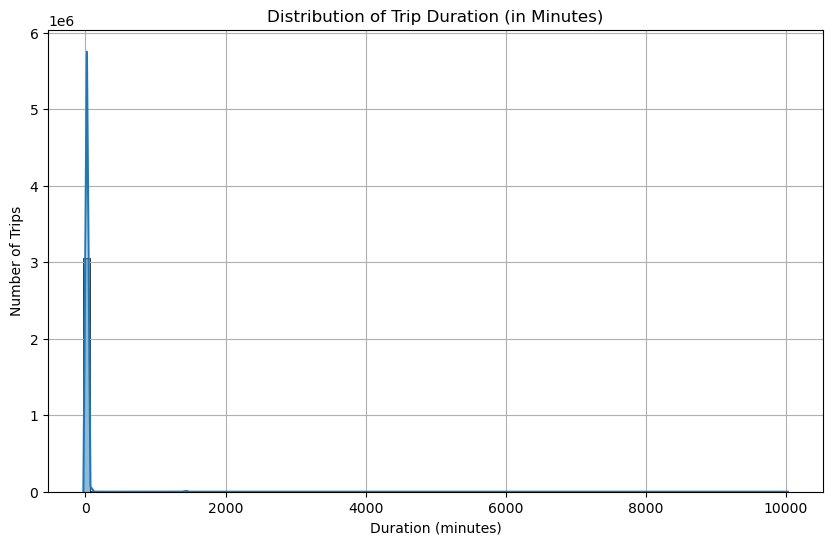

In [11]:
# Look at the distribution of the duration_minutes 
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print(df_taxi_2023['duration'].describe())

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_taxi_2023['duration'], bins=100, kde=True)
plt.title('Distribution of Trip Duration (in Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Trips')
#plt.xlim(0, 100)  # Limit x-axis to exclude extreme outliers
plt.grid(True)
plt.show()

In [13]:
# Since there are a lot of duration less than 1 minutes. We filter only duration between 1 minutes to 99% percentile
df_taxi_2023_filtered = df_taxi_2023[(df_taxi_2023['duration'] >= 1) & (df_taxi_2023['duration'] <= 60)]


# show the result 
df_taxi_2023_filtered.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,lpep_pickup_datetime,lpep_dropoff_datetime,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,...,0.5,0.00,0.0,1.0,14.30,2.5,0.00,2023-01-01 00:32:10,2023-01-01 00:40:36,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,...,0.5,4.00,0.0,1.0,16.90,2.5,0.00,2023-01-01 00:55:08,2023-01-01 01:01:27,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,...,0.5,15.00,0.0,1.0,34.90,2.5,0.00,2023-01-01 00:25:04,2023-01-01 00:37:49,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,...,0.5,0.00,0.0,1.0,20.85,0.0,1.25,2023-01-01 00:03:48,2023-01-01 00:13:25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,...,0.5,3.28,0.0,1.0,19.68,2.5,0.00,2023-01-01 00:10:29,2023-01-01 00:21:19,10.833333


In [15]:
initial_count = len(df_taxi_2023)  # before filtering
filtered_count = len(df_taxi_2023_filtered)  # after filtering

fraction_remaining = filtered_count / initial_count

print(f"Fraction of records remaining: {fraction_remaining:.3f}")

Fraction of records remaining: 0.981


In [17]:
# Feature Engineering 
categorical_variables = ['PULocationID', 'DOLocationID']
#numerical_variables = ['trip_distance']

In [19]:
# Check the types of categorical variables
df_taxi_2023_filtered[categorical_variables].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

In [21]:
# Convert it into "str"
df_taxi_2023_filtered[categorical_variables] = df_taxi_2023_filtered[categorical_variables].astype(str)

# Check the result 
df_taxi_2023_filtered[categorical_variables].dtypes

/var/folders/qw/mns0z74d3t1_nqjy7zgm7mkw0000gn/T/ipykernel_58114/2020572968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_taxi_2023_filtered[categorical_variables] = df_taxi_2023_filtered[categorical_variables].astype(str)


PULocationID    object
DOLocationID    object
dtype: object

In [23]:
# Convert it into dictionary 
train_dicts = df_taxi_2023_filtered[categorical_variables].to_dict(orient = 'records')

In [25]:
# Vectorizer the training variables 
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

# Show the result 
X_train 

<3009173x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018346 stored elements in Compressed Sparse Row format>

In [27]:
# Setup the Prediction_Variables 
predictor = 'duration'
y_train = df_taxi_2023_filtered[predictor].values

# Show the result 
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [29]:
# Train the model 
lr = LinearRegression() 
lr.fit(X_train, y_train)

LinearRegression()

In [31]:
# Make a prediction 
y_pred = lr.predict(X_train)

/var/folders/qw/mns0z74d3t1_nqjy7zgm7mkw0000gn/T/ipykernel_58114/1474463277.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label = 'prediction')
/var/folders/qw/mns0z74d3t1_nqjy7zgm7mkw0000gn/T/ipykernel_58114/1474463277.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, l

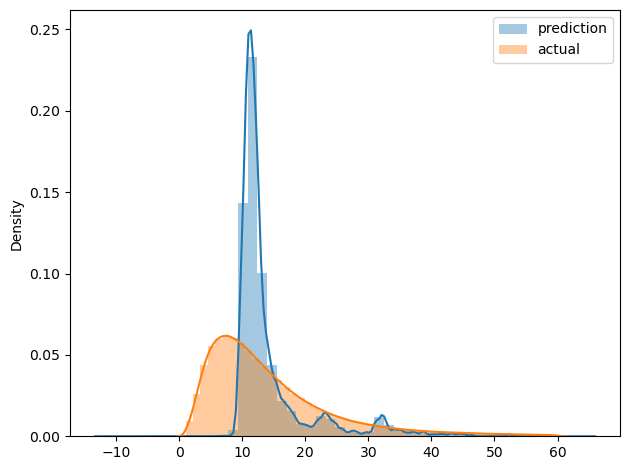

In [33]:
# Visualize the prediction and actual 
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')

plt.legend()
plt.tight_layout()

In [35]:
# Calculate the performance (RMSE)
mean_squared_error(y_train, y_pred, squared = False)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.649261927686161

In [37]:
def read_dataframe(filename):
    "Write a function to read and preprocessing data"
    # Read the dataset
    df_taxi = pd.read_parquet(filename)

    # Adjust dropoff & pickup to pandas datetime 
    df_taxi['tpep_pickup_datetime'] = pd.to_datetime(df_taxi.tpep_pickup_datetime)
    df_taxi['tpep_dropoff_datetime'] = pd.to_datetime(df_taxi.tpep_dropoff_datetime)
    
    # Calculate the duration (drop_off -  pick_up)
    df_taxi['duration'] = df_taxi.tpep_dropoff_datetime - df_taxi.tpep_pickup_datetime
    
    # Adjust the duration in minutes for prediction 
    df_taxi['duration_minutes'] = df_taxi['duration'].dt.total_seconds() / 60

    # Since there are a lot of duration less than 1 minutes. We filter only duration between 1 minutes to 99% percentile
    df_taxi = df_taxi[(df_taxi['duration_minutes'] > 1) & (df_taxi['duration_minutes'] <= 60)]

    # Feature Engineering 
    categorical_variables = ['PULocationID', 'DOLocationID']

    # Convert it into "str"
    df_taxi[categorical_variables] = df_taxi[categorical_variables].astype(str)
    
    return df_taxi

In [39]:
# Read the train and validation datasets
df_train = read_dataframe('../00-Dataset/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../00-Dataset/yellow_tripdata_2023-02.parquet')

In [41]:
len(df_train), len(df_val)

(3008892, 2855630)

In [43]:
# Feature Engineering 
categorical_variables = ['PULocationID', 'DOLocationID']

# Vectorizer the training variables 
dv = DictVectorizer()

# Convert it into dictionary 
train_dicts = df_train[categorical_variables].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

# Create the validation set 
val_dicts = df_val[categorical_variables].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

In [45]:
# Setup the Prediction_Variables 
predictor = 'duration_minutes'
y_train = df_train[predictor].values
y_val = df_val[predictor].values

In [47]:
# Train the model 
lr = LinearRegression() 
lr.fit(X_train, y_train)

# Make a prediction 
y_pred = lr.predict(X_val)


rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 7.81


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [53]:
with open('models/model.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)